In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from IPython.core.display import HTML
from scipy.stats import norm, poisson,expon,lognorm,skewnorm,exponnorm,skew,kstest
from math import pi
%matplotlib inline

In [2]:
# Import the cleaned loan data
loan_data = pd.read_csv('loan_data_eda.csv', index_col=False)

The goal of this project is to create a predictive model for the outcome of loans and for how much capital can be recovered from a charged off loan. In the modeling process there are a large number of hyperparameters and choices to be made in modifying the models. To get a sense for how to choose these parameter values and choices should be made we should inform ourselves via the data itself.

A very important process before the modeling process is to understand the types of data present to get a feel for the considerations that need to be taken into account in the modeling process.

As it is one of the most important considerations for the modelling process, first list the features that
are related to time. This is done by viewing the reference csv file which describes the different features.

There are time dependent features which report the current value of a feature but also there are time dependent
features which aggregate data from the past: an example is the total number of accounts the borrower has that have been
delinquent in the past two years. Even though this is referencing the past, the feature still has a "present" value,
it is just defined by a time window two years in size. Unfortunately there are a large number of time dependent features.

In [4]:
# These functions are used (and sometimes unused but kept for posterity) for statistical analysis regarding the
# distributions of values and otherwise. 


# Function that takes all of the sample values of a feature X (DataFrame.column or NumPy array)
# and returns the equivalent number of samples(variates) from certain SciPy distributions
# specified by keyword argument, "distribution"
def fit_to_data(X, distribution='norm',**kwargs):
    if distribution=='skewnorm':
        params = skewnorm.fit(X)
        variates = skewnorm.rvs(a=params[0], loc=params[1], scale=params[2],  size=len(X))
        
    elif distribution=='lognorm':
        params = lognorm.fit(X)
        variates = lognorm.rvs(s=params[0],loc=params[1],scale=params[2], size=len(X))

    elif distribution=='expon':
        params = expon.fit(X)
        variates = expon.rvs(loc=params[0],scale=params[1], size=len(X))

    elif distribution=='norm':
        params = norm.fit(X)
        variates = norm.rvs(loc=params[0], scale=params[0],size=len(X))

    elif distribution=='exponnorm':
        params = exponnorm.fit(X)
        variates = exponnorm.rvs(params[0],loc=params[1],scale=params[2], size=len(X))

    else:
        dlist = ['skewnorm','norm','expon','lognorm','exponnorm']
        print('Please specify one of the following distributions {},{},{},{},{}'.format(dlist))
        return None
    
    return variates


# Function that is used to contrast kernel density estimate distribution to histogram of actual
# values. 
def hist_density_plot(x, variates,xlabel=None, title=None):
    fig, ax1 = plt.subplots(1,1)
    ax1.hist(x, alpha=0.5,bins=50)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(xlabel)

    axtwin = ax1.twinx()
    sns.kdeplot(variates,ax=axtwin,color='r')
    axtwin.set_title(title)
    axtwin.set_ylabel('Density')
    plt.show()
    return None

# Some of these were previously used but at now unused; they're hanging around incase I decide to use them again.
def imbalance_thresholding(df, threshold):
    mode_percentages = [len(df[df[x] == df[x].mode().values[0]])/len(df) for x in df.columns]
    count_df = pd.DataFrame(mode_percentages, index=df.columns, columns=['percentages'])
    balanced_df = df.loc[:, df.columns.isin(count_df[count_df.percentages < threshold].index.tolist())]
    return balanced_df

def max_pairwise_correlations(df):
    # Produce all correlations to the relations between features
    correlations_ = df.corr()
    # Maximum correlations (excluding auto-correlation)
    correlations_df = correlations_.unstack().to_frame(name='data')
    # Remove the auto-correlations which are trivial / not useful values.
    correlations_no_auto = correlations_df[correlations_df['data']!=1]
    # To pick out the maximum pairwise correlations, 
    maxcvalues = correlations_no_auto[correlations_no_auto['data'] == correlations_no_auto.groupby(level=[0])['data'].transform(max)]
    return maxcvalues

def correlation_thresholding(df, threshold=0.999):
    # Remove features ( technically remove one component of a pair) whose maximum pairwise pearson correlation is
    # greater than threshold, default value 0.999, if no such columns exist then return original DataFrame.
    maxcorr = max_pairwise_correlations(df)
    maxcorr = maxcorr[maxcorr.data > threshold]
    columns_to_drop = maxcorr.sort_values(by='data',ascending=False).reset_index()[::2].level_1.values
    if len(columns_to_drop) > 0:
        return df.drop(columns=columns_to_drop)
    else:
        return df

def clean(df,threshcorr=0.99, threshcount=0.99):
    clean_df = df.copy()
    print('Original shape: ', df.shape)
    clean_df = clean_df.dropna()
    clean_df = imbalance_thresholding(clean_df,threshcount)
    print('pruned shape (filtering out imbalanced features):', clean_df.shape)
    clean_df = correlation_thresholding(clean_df, threshcorr)
    print('pruned shape (filtering out correlated features):', clean_df.shape)
    return clean_df

First, let's motivate why prediction models for this type of data are important along with investigate
one of the time dependent variables. Specifically, let's view the time series of issued loan dates, aggregated by month.

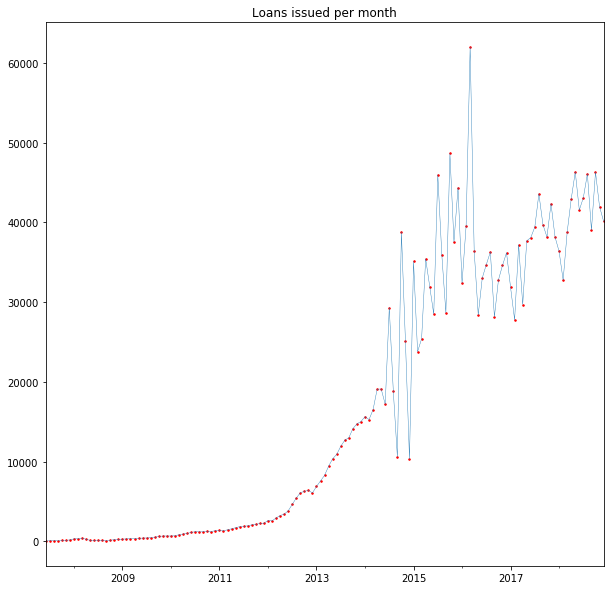

In [5]:
issued = loan_data.issue_d.value_counts()
issued.index = pd.to_datetime(loan_data.issue_d.value_counts().index)
issued.sort_index(inplace=True)
issued.plot(marker='.', color='red',linestyle='none',markersize=3,figsize=(10,10))
issued.plot(linewidth=0.4)
plt.title('Loans issued per month')
plt.show()

The erratic nature of the monthly loans issued obscures the growth trend; aggregate by year to get a better
depiction of average growth.

As previously mentioned, the amount of money lost (or at least needed to be recovered) by charged-off loans is in the billions. Using the Lending Club loan dataset the main goals are to create a predictive model for whether a loan will be charged off or not as well as a model for the amount of money that can be recovered from charged off loans. Before we begin on the production of the main deliverables it’s good to get a good feel for the dataset. In this dataset there are categorical variables in the form of strings, discrete numerical variables, and continuous numerical variables. The data can also be segmented into information describing the borrower (geographical location, income, etc.) and information about the loan (principal amount, interest rate, etc.). There are also features that are time dependent and can be naturally visualized as a time series. One example of a time dependent feature is the date when each loan was issued. Aggregating by year and performing a polynomial fit assuming parabolic growth for the number of loans issued per year results in a respectable r-squared value (coefficient of determination) value of 0.92. This nonlinear growth implies that our main deliverable, the model which predict the outcome of a loan should become more important over time. 

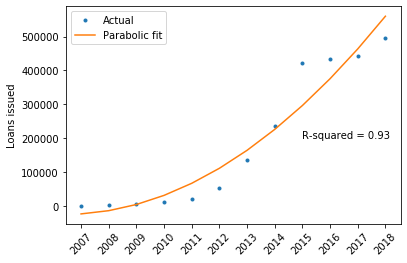

In [6]:
# Answer to the question: How does the number of issued loans per annum grow over time? Answer: Parabolically.

# Sum over each year to get loans issued per year.
yeargroups = issued.groupby(by=issued.index.strftime('%Y')).sum()
# There happen to be 12 years in the values, use these as the domain of
# values to fit on. 
x = np.arange(12)

# It looks parabolic, so this is what was tried first. It produced a good
# result so I stopped here. 
a, b, c = np.polyfit(x, yeargroups.values, deg=2)
polyfit_r2 = r2_score(yeargroups.values, a*x**2 + b*x + c)
plt.plot(yeargroups.index, yeargroups.values,marker='.',linestyle='none')
plt.plot(x, a*x**2 + b*x + c)
plt.xticks(rotation=45)
plt.ylabel('Loans issued')
plt.text(8, 200000, 'R-squared = %0.2f' % polyfit_r2)
plt.legend(('Actual', 'Parabolic fit'))
_ = plt.show()

A parabolic fit seems to capture the recent average growth trend but with the cavaet that this growth is unsustainable. This is only a figure to give a sense of how the loans have grown ***up to the present moment***. Aggregating by the (top three) statuses of the loan shows the time distribution of when fully paid, current and charged off loans. All of the loans have terms of three or five years so it's understandable that the approximate maximum of the fully paid loans and charged off loans occurs in the same range, three to five years ago. (The most current date in the data set is December 1st 2018).

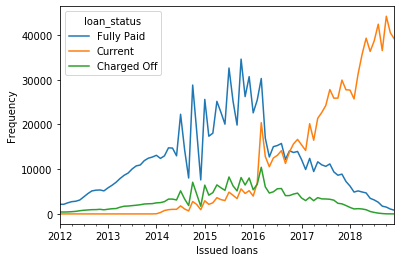

In [7]:
time_series_loan_status = loan_data.groupby('loan_status').issue_d.value_counts()
time_series_loan_status = time_series_loan_status.unstack().swapaxes('index','columns')
time_series_loan_status.index = pd.to_datetime(time_series_loan_status.index)
time_series_loan_status = time_series_loan_status.fillna(value=0)
top_3_statuses = time_series_loan_status.loc[:, time_series_loan_status.sum().sort_values(ascending=False).index[:3]].astype(int)
top_3_statuses_from_2012_on = top_3_statuses.sort_index()['2012':]
_ = top_3_statuses_from_2012_on.plot()
_ = plt.xlabel('Issued loans')
_ = plt.ylabel('Frequency')

One such variable is the percentage of available credit being utilized by the borrower. Plotting this variable shows some borrowers are above the theoretical threshold of 100%. This is a good example of why generalization is so important as values which are **outside of what would be expected** occur frequently in real data. 

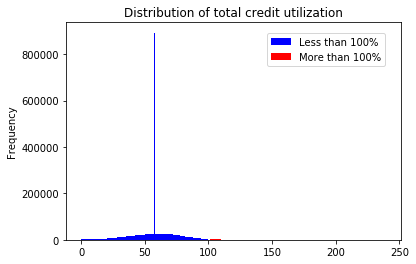

In [8]:
# Separate into above the 100% threshold and below
more_than_max_credit = loan_data[loan_data.all_util > 100]
less_than_max_credit = loan_data[loan_data.all_util <= 100]

leftax = less_than_max_credit.all_util.plot.hist(bins=100, color='b')
more_than_max_credit.all_util.plot.hist(bins=75,color='r')
plt.legend(('Less than 100%', 'More than 100%'), loc=(0.6,0.8))
plt.title('Distribution of total credit utilization')
_ = plt.show() 

Firstly, the large spike is due to imputation of values at the mean. 

Looking at this distribution, the red region indicates that  number of loan borrowers are above their credit limit; the reason for this is unknown but I'll hypothesize that this among with other properties can help stratify the borrowers into fundamentally different classes.  Look at the loan amounts and average current balances to see the general loan information of each type of borrower

In [9]:
print('The average balance for borrowers utilizing more than 100% of their credit: ${:0.2f}'.format(
      more_than_max_credit.tot_cur_bal.mean()))
print('The average balance for borrowers utilizing less than 100% of their credit: ${:0.2f}'.format(
    less_than_max_credit.tot_cur_bal.mean()))

The average balance for borrowers utilizing more than 100% of their credit: $182575.92
The average balance for borrowers utilizing less than 100% of their credit: $142191.83


In [10]:
print('The average loan amount for borrowers utilizing more than 100% of their credit: ${:0.2f}'.format(
      more_than_max_credit.loan_amnt.mean()))
print('The average loan amount for borrowers utilizing less than 100% of their credit: ${:0.2f}'.format(
    less_than_max_credit.loan_amnt.mean()))

The average loan amount for borrowers utilizing more than 100% of their credit: $11729.86
The average loan amount for borrowers utilizing less than 100% of their credit: $15071.79


The average current balance is actually greater for people utilizing less of their credit,
This is not indicative of not paying off loans; it just indicates that people that use less credit on
average get loans with higher principal amounts. To display these differences we can look at the distributions of 
average current balance.

Look at the largest differences in mean values for sample populations above and below the credit limit. 

To get a sense as to whether the separation by credit utilization implies look at differences in summary statistics between the two populations. The top ten largest differences in means of all features are shown.  This doesn't prove anything, but serves as a quick check for the hypothesis. The second quantity is interesting and somewhat easy to investigate so that's what I chose to focus on. It is concerned with the total balance excluding mortgages; a difference in the mean implies that there is a discrepancy between the two groups in regards to mortgage balances. This hints at there being a differences in the home ownership status between the sample populations.

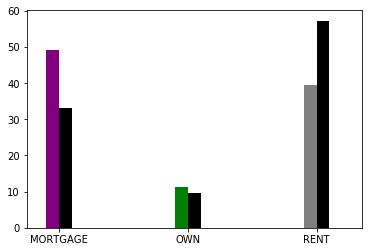

In [11]:
# Plot the percentages of home ownership status of data above and below credit limit. 
moreind = more_than_max_credit.index
lessind = less_than_max_credit.index
home_more = loan_data.loc[moreind,'home_ownership'].value_counts().sort_index()#.values
home_less = loan_data.loc[lessind,'home_ownership'].value_counts().sort_index()#.values
home_less = 100 * home_less.loc[['MORTGAGE','OWN','RENT']] / home_less.sum()
home_more = 100 * home_more.loc[['MORTGAGE','OWN','RENT']] / home_more.sum()

fig = plt.figure() 
ax = fig.add_subplot(111) 

width = 0.4
home_less.plot.bar(ax=ax, rot=0,color=['purple','green','gray'],position=1,width=0.1)
home_more.plot.bar(ax=ax,rot=0,color=['black','black','black'],position=0,width=0.1)
_ = plt.show()

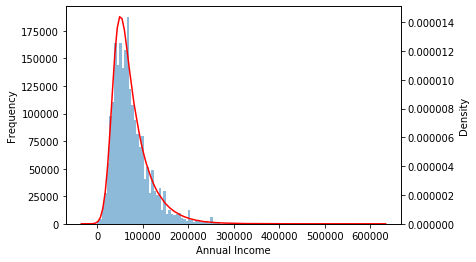

In [12]:
annual_inc_without_extreme_outliers = loan_data.annual_inc[loan_data.annual_inc < loan_data.annual_inc.quantile(0.99)]
annual_inc_norm_variates = fit_to_data(annual_inc_without_extreme_outliers, distribution='exponnorm')
hist_density_plot(annual_inc_without_extreme_outliers, annual_inc_norm_variates, xlabel='Annual Income')

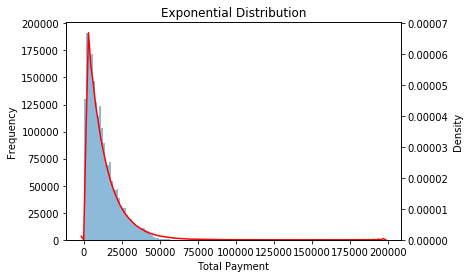

In [13]:
total_payment_exp_variates = fit_to_data(loan_data.total_pymnt, distribution='expon')
hist_density_plot(loan_data.total_pymnt, total_payment_exp_variates, xlabel='Total Payment',title='Exponential Distribution')

An alternative model for an exponentially distributed random variable Y is to take the log and model
it with either a skew-normal or normal distribution. This is likely a better choice because the skewness of the variates is ***not*** what would be expected from an exponential distribution, where it is a constant value independent of the commonly used exponential distribution parameter, $\lambda$.

There is a cavaets to this, however.In order to apply the logarithm, the values equal to zero have to be removed to avoid transformed values of negative infinity; this is throwing away data from the sample distribution which is a no-no.

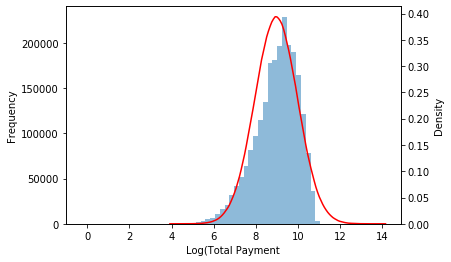

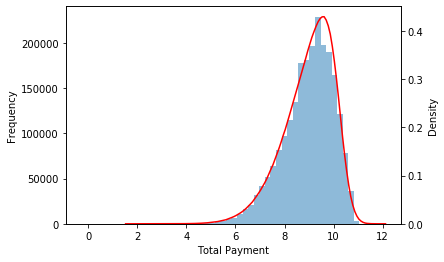

In [14]:
log_total_pymnt_gt_0 = loan_data.total_pymnt[loan_data.total_pymnt>0].apply(np.log)
total_payment_logn_variates = fit_to_data(log_total_pymnt_gt_0, distribution='lognorm')
hist_density_plot(log_total_pymnt_gt_0, total_payment_logn_variates, xlabel='Log(Total Payment')
total_payment_skewn_variates = fit_to_data(log_total_pymnt_gt_0, distribution='skewnorm')
hist_density_plot(log_total_pymnt_gt_0, total_payment_skewn_variates, xlabel='Total Payment')

Both the lognormal and skew normal distributions seem to yield the same results; this seems off.

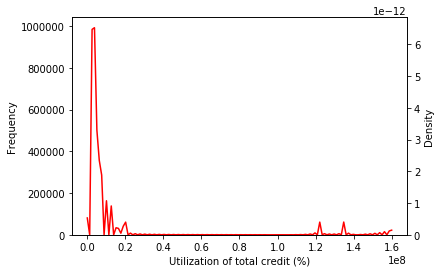

In [16]:
all_util_lognorm_variates = fit_to_data(loan_data.all_util, distribution='lognorm')
hist_density_plot(loan_data.all_util, all_util_lognorm_variates, xlabel='Utilization of total credit (%)')

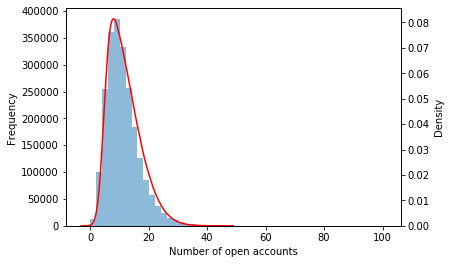

In [17]:
open_acc_skewnorm_variates = fit_to_data(loan_data.open_acc, distribution='skewnorm')
hist_density_plot(loan_data.open_acc, open_acc_skewnorm_variates, xlabel='Number of open accounts')

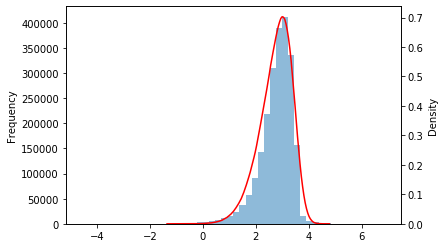

In [18]:
log_dti = loan_data.dti[loan_data.dti>0].apply(np.log)
dti_skn_variates = fit_to_data(log_dti, distribution='skewnorm')
hist_density_plot(log_dti, dti_skn_variates)

There are also variables that one might imagine would have a nice normal distribution but the reality is anything
but. For example, the distribution of loan principal amounts.

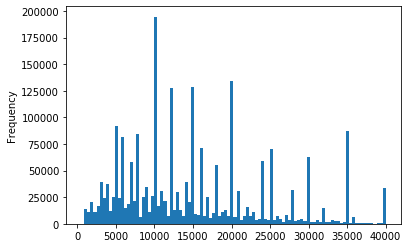

In [19]:
loan_data.loan_amnt.plot.hist(bins=100)
plt.show()

Why is this distribution so strange? As can be seen, the distribution seems to be clustered around "pretty", round numbers like
multiples of five thousand and ten thousand. To show this explicitly, let's look at the top ten most frequent loan values. This is an interesting effect that can likely just be ascribed to a human effect. This makes the loan amount distribution some strange quasi-discrete distribution.

In [20]:
loan_data.loan_amnt.value_counts().sort_values(ascending=False).head(10)

10000.0    187236
20000.0    131006
15000.0    123226
12000.0    121681
35000.0     86285
5000.0      84765
8000.0      75033
6000.0      72089
25000.0     66453
16000.0     66418
Name: loan_amnt, dtype: int64

Another quantity that I would have guessed would have a normal distribution is the total current balance of all accounts.
Plotting the histogram shows yet another distribution which betrayed my expectation.

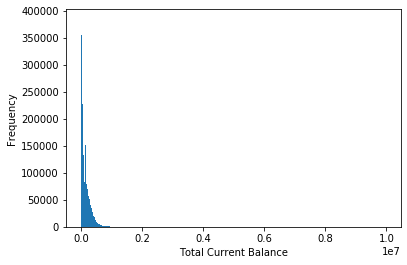

In [21]:
loan_data.tot_cur_bal.plot.hist(bins=500)
plt.xlabel('Total Current Balance')
_ = plt.show()

I'll employ a logarithm transformation to get another perspective for this distribution. Again this requires dropping the zeros (which are numerous) such that the transformed data does not contain "-inf" values.

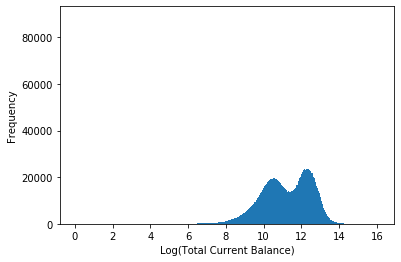

In [22]:
loan_data[loan_data.tot_cur_bal>0].tot_cur_bal.apply(np.log).plot.hist(bins=500)
plt.xlabel('Log(Total Current Balance)')
_ = plt.show()

The result of the logarithmic transformation is a bimodal distribution; to get a vague sense of why there are two local maxima, let's split the data in half by the median value and take the difference of the summary statistics of all features.

In [23]:
statdiff = less_than_max_credit.describe()-more_than_max_credit.describe()
statdiff = statdiff.apply(np.abs).sort_values(by='mean',axis=1, ascending=False).apply(np.round,args=(2,))
statdiff.loc['mean',:].sort_values(ascending=False)[:10].to_frame()

,mean
total_bal_il,79187.61
total_bal_ex_mort,74942.79
total_il_high_credit_limit,54839.00
tot_cur_bal,40384.08
emp_title,18514.87
total_rev_hi_lim,18316.96
total_bc_limit,12107.41
annual_inc,8304.97
bc_open_to_buy,8097.11
revol_bal,5452.87


In [24]:
more_tot_cur_bal = loan_data[loan_data.tot_cur_bal > loan_data.tot_cur_bal.median()]
less_tot_cur_bal = loan_data[(loan_data.tot_cur_bal < loan_data.tot_cur_bal.median())&(loan_data.tot_cur_bal > 0)]

In [25]:
describe_diff = less_tot_cur_bal.describe()-more_tot_cur_bal.describe() 
abs_describe_diff = describe_diff.apply(np.abs).sort_values(by='mean',axis=1, ascending=False).apply(np.round,args=(2,))
abs_describe_diff.loc['mean',:].sort_values(ascending=False)[:10].to_frame()

,mean
tot_hi_cred_lim,241029.31
tot_cur_bal,217348.51
total_bal_ex_mort,38419.32
total_il_high_credit_limit,31417.20
annual_inc,30501.88
avg_cur_bal,19491.02
total_bal_il,19322.43
total_rev_hi_lim,16690.60
revol_bal,10590.89
total_bc_limit,9320.15


The large difference in mean in total current balance is a result of how we split the data; there are also large differences in the total credit limit on all accounts and the total balance excluding mortgages.  

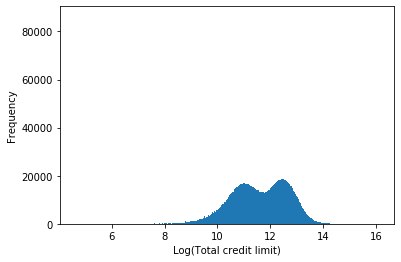

In [26]:
loan_data[loan_data.tot_hi_cred_lim>0].tot_hi_cred_lim.apply(np.log).plot.hist(bins=500)
plt.xlabel('Log(Total credit limit)')
_ = plt.show()

The distribution of total credit limit has the same form as total current balance; this explains why the difference of means is the same order as total current balance. This isn't very useful as it can't really be used to classify the different maxima because itself is a continuous variable. For the total balance excluding mortgage however, we can see how the total current balance is distributed for different home ownership categories.

In [27]:
moreind = more_tot_cur_bal.index
lessind = less_tot_cur_bal.index

more_tot_cur_bal_home_ownership = loan_data.loc[moreind,'home_ownership'].value_counts().sort_index()
less_tot_cur_bal_home_ownership = loan_data.loc[lessind,'home_ownership'].value_counts().sort_index()

less_tot_cur_bal_home_ownership = less_tot_cur_bal_home_ownership.loc[['MORTGAGE','OWN','RENT']] 
more_tot_cur_bal_home_ownership = more_tot_cur_bal_home_ownership.loc[['MORTGAGE','OWN','RENT']]

less_tot_cur_bal_home_ownership = 100 * less_tot_cur_bal_home_ownership / less_tot_cur_bal_home_ownership.sum()
more_tot_cur_bal_home_ownership = 100 * more_tot_cur_bal_home_ownership / more_tot_cur_bal_home_ownership.sum()

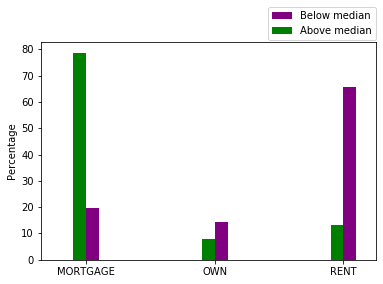

In [28]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
width = 0.4
less_tot_cur_bal_home_ownership.plot.bar(ax=ax, rot=0,color=['purple','purple','purple'],position=0,width=0.1)
more_tot_cur_bal_home_ownership.plot.bar(ax=ax,rot=0,color=['green','green','green'],position=1,width=0.1)
ax.legend(('Below median','Above median'),loc=(0.68,1.01))
ax.set_ylabel('Percentage')
plt.show()

There seems to be a large difference in the home ownership status between each mode of the distribution. Let's visualize this by plotting the total current balance (log) distribution with respect to each category.

In [39]:
topthree_homeownership = loan_data.loc[loan_data.home_ownership.isin(['RENT','OWN','MORTGAGE']), :]
topthree_homeownership = topthree_homeownership[topthree_homeownership.tot_cur_bal > 0]

In [40]:
topthree_homeownership.loc[:,'log_tot_cur_bal'] = topthree_homeownership.tot_cur_bal.apply(np.log)

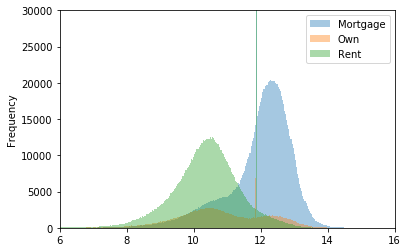

In [49]:
topthree_homeownership.groupby(by='home_ownership').log_tot_cur_bal.plot.hist(bins=500,alpha=0.4)
plt.legend(('Mortgage','Own','Rent'))
plt.xlim([6,16])
plt.ylim([0,30000])
_ = plt.show()

Own and mortgage still look like they're non-normal but the total current balance distribution for renters
does seem normal. This almost seems like it's hinting at the possibility that there are "hidden categories"
of customers. The idea I have in my head at least is that perhaps there is a useful way of subdividing or partitioning
the data such that these subsets could each be treated as their own population; that is to say, each would have a separate model instead of there being single models for loan outcome prediction and recovered capital regression. The problem is that
the next step forward, breaking down the mortgage and own categories doesn't seem to be as obvious after repeating the summary statistics differences.

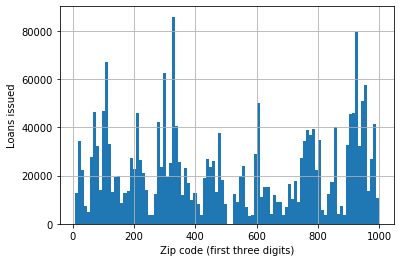

In [58]:
geog = loan_data[loan_data.zip_code!='Missing'].zip_code.str.split('xx').str.join(sep='').astype(float)
geog.hist(bins=100)
plt.xlabel('Zip code (first three digits)')
plt.ylabel('Loans issued')
_ = plt.show()

Looking up the top five zip codes correspond to: 

Brooklyn, NY. 
Oakland, CA. 
Dallas, TX. 
Chicago, IL. 
Atlanta, GA.

Need to take population into account to see if there is any geographical clustering. 

The goal of stratifying the earliest credit line by the purpose of the loan was to see if different age demographics use loans for different purposes. This would be measured by differences in the mean between these stratified distributions, as I believe it is a fair assumption that everyone gets their first credit line (earliest) around the same age.

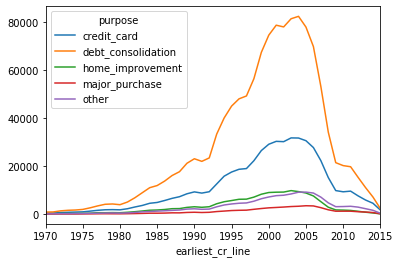

In [61]:
dt_loan_data = loan_data[['purpose','earliest_cr_line']]
dt_loan_data = dt_loan_data[dt_loan_data.earliest_cr_line!='Missing']
dt_loan_data = dt_loan_data.set_index('earliest_cr_line')
dt_loan_data.index = pd.to_datetime(dt_loan_data.index)

top_five_purposes = dt_loan_data.groupby([dt_loan_data.index.year,'purpose']).size().unstack().sum().sort_values(ascending=False)[:5].index.tolist()
top_five_purposes_df = dt_loan_data[dt_loan_data.purpose.isin(top_five_purposes)]
_ = top_five_purposes_df.groupby([top_five_purposes_df.index.year,'purpose']).size().unstack().loc[1970:].plot()

Wanted to investigate what the relationship between subgrades and grades are; turns out to be pretty boring since
subgrades are uniformly distributed
across grades (each of the five subgrades is approximately 20% of the grade's values).

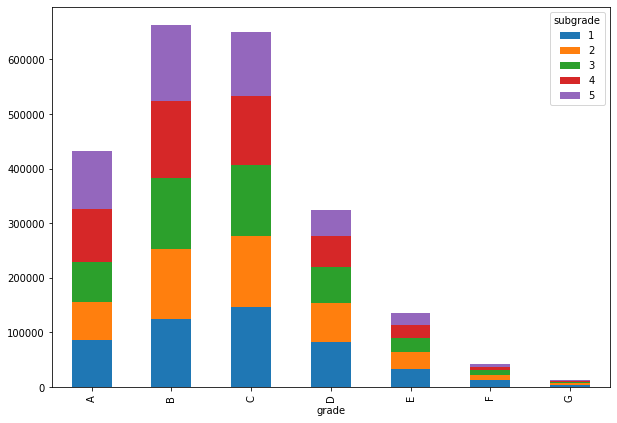

In [62]:
# Subgrades are of format Letter-number (e.g. C1). 
letters, subnumber = loan_data['sub_grade'].str.slice(0,1), loan_data['sub_grade'].str.slice(1).astype(int)
gradesubgrade_df = pd.concat([letters,subnumber],axis=1)
gradesubgrade_df.columns=['grade','subgrade']

# Plot of loan grades and subgrades; it appears that subgrades uniformly stratify each grade
gradesubgrade_df.groupby(['grade','subgrade']).size().unstack().plot.bar(stacked=True,figsize=(10,7))
plt.show()

Going further, let us transform the loan status categorical variable to a binary variable, and then
we can use this in logistic regression and other techniques. The actual transformation and saving of this data
was done in the data cleaning step.

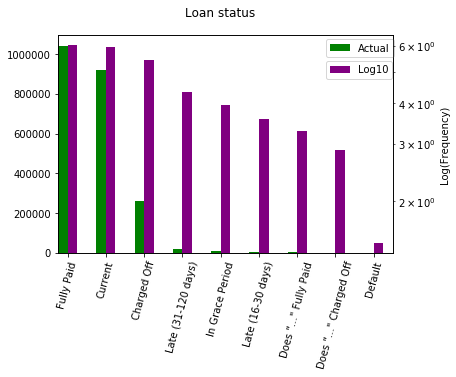

In [64]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
loan_statuses = loan_data.loc[:,'loan_status'].value_counts()
loan_statuses_tmp = loan_statuses.reset_index()
loan_statuses_tmp.loc[loan_statuses_tmp['index'].apply(len)>20, 'index'] = loan_statuses_tmp.loc[loan_statuses_tmp['index'].apply(len)>20, 'index'].apply(lambda x : x[:5]+'"..." '+x[40:])
loan_statuses_tmp = loan_statuses_tmp.set_index(keys=['index'])
loan_statuses_tmp.index.name = ''
loan_statuses_tmp.plot.bar(rot=75,ax=ax1, width=0.25, position=1,color='green')
loan_statuses_tmp.apply(np.log10).plot.bar(rot=75, ax=ax2,width=0.25, position=0,color='purple')
fig.suptitle('Loan status')
ax.set_ylabel('Frequency')
ax2.set_ylabel('Log(Frequency)')
ax2.set_yscale('log')
ax1.legend(('Actual',),loc=(0.8, 0.9))
ax2.legend(('Log10',), loc=(0.8,0.8))
plt.show()

As we can see by this figure, the vast majority of loans fall into three
categories: "Fully paid", "Current", and "Charged Off".

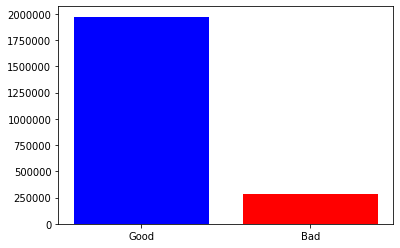

In [71]:
binary_loan_status = pd.read_csv('binary_loan_status.csv',index_col=False)
badcount = int(binary_loan_status.sum())
goodcount = int(len(binary_loan_status)-badcount)
plt.figure()
plt.bar(['Good','Bad'],[goodcount, badcount],color=['blue','red'])
plt.show()

Perhaps one of the most important tasks is to determine which variables are time dependent as forgetting to do so
can easily introduce bias by virtue of data snooping. The following lists are all of the features that make reference to past or present values, as one can see it is a long list. There are a number of questions to be answered; how should these be accounted for in the model, specifically the cross-validation, process? Are time dependent variables which aggregate past data,
e.g. number of delinquent accounts in the ***past two years***, the same as present values?

In [72]:
# Time dependent numerical columns
# Any variables involving recovered funds will taint recovery amount predictions. 
# Can technically include one column and then split time series with TimeSeriesSplit. 
time_dependent_numerical_features = ['acc_now_delinq', 'acc_open_past_24mths',
 'chargeoff_within_12_mths','collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt',
 'inq_last_12m', 'inq_last_6mths','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m','pct_tl_nvr_dlq','tot_coll_amt',
 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp']

time_dependent_categorical_features = ['earliest_cr_line','initial_list_status', 'last_credit_pull_d','last_pymnt_d','emp_length']
# issue_d is time dependent but this will allow for investigation/application of time dependence functions


# time_sorted_index = pd.to_datetime(categorical_data.issue_d).sort_values().index

The main concern is the order of these time dependent variables in regards to training and testing data sets for the models as well as for cross validation. If future data is accidentally used in the training then the predictions are essentially worthless. This goes down all the way to the level of normalization; that is, if normalizing the data then one should be sure to only normalize with respect to the training set.

As a reminder, there are continuous and discrete numerical variables as well as categorical variables (converted to
discrete numerical variables by transformation by integer codes). With over two million samples, my first thought was
that most of these continuous variables would be normally distributed. This was a result of being new to financial data
and I suppose naivety. As I'll show, there is a variety of distributions which the continuous variables take; some of which follow no recognizable or nice form.

The goal of this particular portion of the statistical analysis is to get a feel for how the variables are distributed because 
there are hyperparameters such as class weighting that can be very beneficial depending on the results of this investigation.

First, To demonstrate how imbalanced some of the data features are, let's look at the percentage of data values that the mode of each feature represents.

In [87]:
modepercents = 100 * loan_data.mode() / len(loan_data)
modepercents = modepercents.swapaxes('index','columns').sort_values(by=0, ascending=False)[:10]

Highly imbalanced data and highly correlated data require special care and considerations as they both seem to invite improper manipulation. An example would be to  modify the data by pruning features with pearson correlation above a certain threshold.
Let's look at why I even bring this method up by examining the pairwise correlations.

In [88]:
max_pairwise_correlations(loan_data).sort_values(by='data',ascending=False)[::2]

,,data
out_prncp_inv,out_prncp,0.999999
funded_amnt,loan_amnt,0.999755
total_pymnt,total_pymnt_inv,0.999394
funded_amnt_inv,funded_amnt,0.999341
open_acc,num_sats,0.989056
...,...,...
sec_app_earliest_cr_line,next_pymnt_d,0.106983
home_ownership,sub_grade,0.074632
issue_d,last_pymnt_d,0.058935
sec_app_mths_since_last_major_derog,sec_app_mort_acc,0.052615


There are a number of pairs of features with pearson correlation scores greater than 0.999 for a specific and relatively obvious reason. Specifically, some features are essentially identical; an example being: the funded amount of a loan and funded amount of a loan from investors. If investors represent the overwhelming majority of loan funding then these features are nearly identical which seems to be the case upon inspection.The best course of action seems to be to leave the features untouched and to simply include considerations for these properties such as regularization and balanced class weighting. 

In [89]:
# The following functions are hand made sampling and statistical testing functions to show a more fundamental knowledge,
# more than just calling the associated SciPy function.

# Sampling distribution of summary statistic (func) replicates produced by permutation replicates
# (sampling without replacement)
def permutation_replicates(data1, data2, func, size=10000):
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

def permutation_sample(data1, data2):
    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def diff_of_mean(data1, data2):
    return np.mean(data1)-np.mean(data2)

# Sampling distribution of summary statistic (func) replicates produced by bootstrap sampling
# (sampling with replacement)
def bootstrap_replicates(data, func, size=10000):
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

def difference_of_mean_p_value(data1, data2, size=1000):
    mean_diff = diff_of_mean(data1, data2) 
    print('The empirical difference of means is {:0.2f}'.format(mean_diff))
    # Compute samples of difference of means: bs_diff_replicates
    mean_diff_perm_replicates = permutation_replicates(data1, data2, diff_of_mean, size=size)

    p = np.sum(mean_diff_perm_replicates >= mean_diff) / len(mean_diff_perm_replicates)
    # Print the results
    print('difference of means = ${:0.2f}'.format(mean_diff))
    print('p-value =', p)
    return p, mean_diff_perm_replicates

Need to account for time series data by either eliminating it from the dataset to avoid snooping or account for it. 
There aren't variables which has day-to-day interactions so perhaps there is enough time for the data to be uncorrelated. 

Splitting into numerical data for linear regression and object data for classification. The reason for this is to 1. reduce the number of time dependent variables in either set (is this sample bias?) 
What about the variables that aren't explicitly time variables but are implicitly dependent on time? For instance, in order to have a recovery amount, the loan must have been charged off, which means it is likely past the maturity date of the loan, which means it contains time dependent data. 

Some distributions were shown earlier, but to claim that the distributions are accurate depictions of our sampling distributions, statistical testing is required. This could come in many different flavors but because I mainly want to compare sample to predicted distributions I will employ the Kolmogorov-Smirnov test to the sets of variates created above.

In [92]:
# Claim was exponnormal
annual_inc_kstest = kstest(annual_inc_without_extreme_outliers,'exponnorm')

In [ ]:
# Claim was exponential distribution
# Claim was exponnormal
total_pymnt_kstest = kstest(loan_data.total_pymnt,'expon')

In [ ]:
# Claim was exponnormal
log_total_pymnt_gt_0_kstest_lognorm = kstest(log_total_pymnt_gt_0,'lognorm')

In [ ]:
# Claim was exponnormal
log_total_pymnt_gt_0_kstest_skewnorm = kstest(log_total_pymnt_gt_0,'skewnorm')

In [ ]:
# Claim was exponnormal
all_util_kstest = kstest(loan_data.all_util,'lognorm')

In [ ]:
# Claim was exponnormal
open_acc_kstest = kstest(loan_data.open_acc,'skewnorm')

In [ ]:
# Claim was exponnormal
log_dti _kstest = kstest(log_dti,'skewnorm')